# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_score,f1_score

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5



### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)#分类到多少class

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = x.view(-1, 8 * 6 * 6)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return x

### Optimizer

In [6]:
def initial_Model():
    model = ConvNet()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    return model,optimizer,scheduler

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [7]:
class FocalLoss(nn.Module): 
    def __init__(self, gamma=0.5, alpha=None): 
        super(FocalLoss, self).__init__() 
        self.gamma = gamma 
        self.alpha = alpha 
    def forward(self, inputs, targets): 
        # 计算交叉熵损失 
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha) 
        # 计算焦点损失 
        pt = torch.exp(-ce_loss) 
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss 
        return focal_loss.mean()

In [8]:
def train_batch(model, image, target, criterion):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    if not(isinstance(criterion,nn.CrossEntropyLoss)): 
        target = F.one_hot(target,num_classes = 10).float()
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [9]:

def test_batch(model, image, target, criterion):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    if not(isinstance(criterion,nn.CrossEntropyLoss)):
        target = F.one_hot(target,num_classes = 10).float()
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

In [10]:
def model_training(model,criterion,optimizer,scheduler):
    training_loss = []
    training_acc = []
    training_precision = []
    testing_loss = []
    testing_acc = []
    testing_precision = []
    training_f1 = []
    testing_f1 = []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0
        big_target = []
        big_preds = []
        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

        # train model
            outputs, loss = train_batch(model, image, target, criterion)
            _, preds = torch.max(outputs, 1)        
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)
            big_target.extend(target.cpu().numpy())
            big_preds.extend(preds.cpu().numpy())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_f1 = f1_score(big_target, big_preds, average='macro', zero_division=0)
        epoch_precision = precision_score(big_target, big_preds, average='macro', zero_division=0)
        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} f1: {epoch_f1:.4f}')
        training_f1.append(epoch_f1)
        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())
        training_precision.append(epoch_precision)

        # change learning rate
        scheduler.step()


        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0
            big_val_target = []
            big_val_preds = []

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target, criterion)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)
                big_val_target.extend(target.cpu().numpy())
                big_val_preds.extend(preds.cpu().numpy())
                



            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            val_precision = precision_score(big_val_target,big_val_preds,average='macro', zero_division=0)
            val_f1 = f1_score(big_val_target, big_val_preds, average='macro', zero_division=0)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} f1: {val_f1:.4f}')

            testing_loss.append(val_loss)
            testing_f1.append(val_f1)
            testing_acc.append(val_acc.cpu().detach().numpy())
            testing_precision.append(val_precision)

            # save the model in last epoch
            if (epoch +1) == NUM_EPOCHS:

                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
                
    x = [i for i in range(1, NUM_EPOCHS+1)]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(x,training_loss,color = 'blue', label='Training Loss')
    plt.scatter(x,testing_loss,color = 'red', label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.scatter(x,training_acc,color = 'blue', label='Training Accuracy')
    plt.scatter(x,testing_acc,color = 'red', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.tight_layout
    plt.show()


                
    return training_acc,training_loss,training_precision,testing_acc,testing_loss,testing_precision,training_f1,testing_f1 

Epoch: 1/30 Train Loss: 0.0009 Acc: 0.0995 Precision: 0.0997 f1: 0.0980
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 f1: 0.0182
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.1012 Precision: 0.1008 f1: 0.0982
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 f1: 0.0182
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.1002 Precision: 0.0999 f1: 0.0985
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 f1: 0.0182
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.0993 Precision: 0.0993 f1: 0.0978
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 f1: 0.0182
Epoch: 5/30 Train Loss: 0.0009 Acc: 0.0992 Precision: 0.0990 f1: 0.0976
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 f1: 0.0182
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.1027 Precision: 0.1032 f1: 0.0987
Begin test......
Test Loss: 0.0008 Acc: 0.1003 Precision: 0.0750 f1: 0.0190
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.0959 Precision: 0.0956 f1: 0.0937
Begin test......
Test Loss: 0.0008 Acc: 

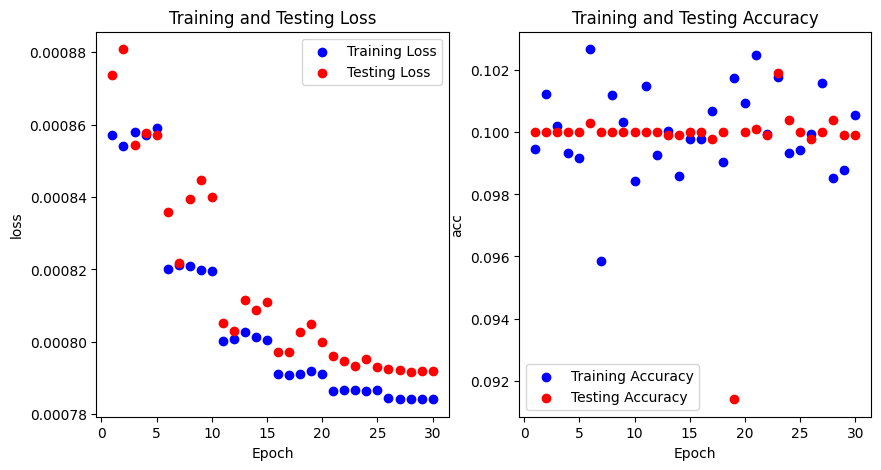

In [11]:
model,optimizer,scheduler = initial_Model()
L1_tn_acc,L1_loss_tn_loss,L1_tn_p,L1_tt_acc,L1_tt_loss,L1_tt_p,L1_tn_f1,L1_tt_f1  = model_training(model,nn.L1Loss(),optimizer,scheduler)

Epoch: 1/30 Train Loss: 0.0146 Acc: 0.3088 Precision: 0.3029 f1: 0.3029
Begin test......
Test Loss: 0.0132 Acc: 0.4029 Precision: 0.4080 f1: 0.3819
Epoch: 2/30 Train Loss: 0.0135 Acc: 0.3689 Precision: 0.3658 f1: 0.3655
Begin test......
Test Loss: 0.0129 Acc: 0.3952 Precision: 0.4275 f1: 0.3722
Epoch: 3/30 Train Loss: 0.0135 Acc: 0.3738 Precision: 0.3705 f1: 0.3702
Begin test......
Test Loss: 0.0124 Acc: 0.4223 Precision: 0.4296 f1: 0.4097
Epoch: 4/30 Train Loss: 0.0132 Acc: 0.3847 Precision: 0.3820 f1: 0.3814
Begin test......
Test Loss: 0.0123 Acc: 0.4332 Precision: 0.4551 f1: 0.4247
Epoch: 5/30 Train Loss: 0.0131 Acc: 0.3925 Precision: 0.3895 f1: 0.3893
Begin test......
Test Loss: 0.0129 Acc: 0.4259 Precision: 0.4263 f1: 0.4162
Epoch: 6/30 Train Loss: 0.0122 Acc: 0.4331 Precision: 0.4303 f1: 0.4299
Begin test......
Test Loss: 0.0115 Acc: 0.4666 Precision: 0.4852 f1: 0.4632
Epoch: 7/30 Train Loss: 0.0121 Acc: 0.4396 Precision: 0.4358 f1: 0.4364
Begin test......
Test Loss: 0.0115 Acc: 

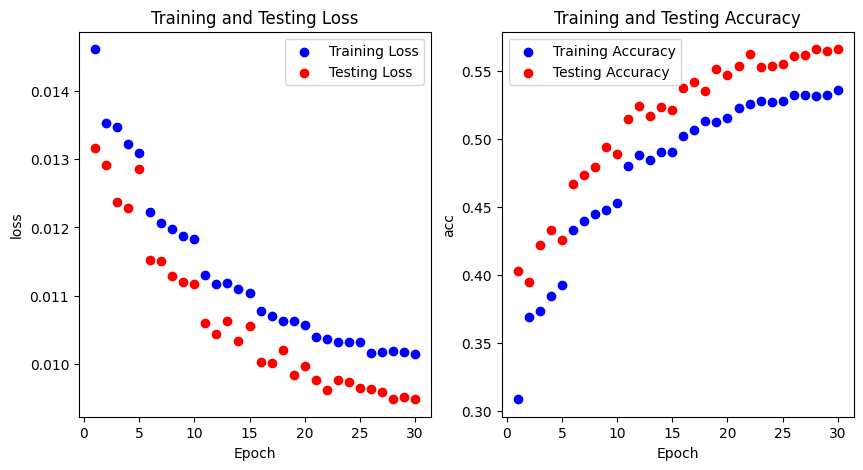

In [12]:
model,optimizer,scheduler = initial_Model()
CE_tn_acc,CE_tn_loss,CE_tn_p,CE_tt_acc,CE_tt_loss,CE_tt_p,CE_tn_f1,CE_tt_f1 = model_training(model,nn.CrossEntropyLoss(),optimizer,scheduler)

Epoch: 1/30 Train Loss: 0.0114 Acc: 0.2644 Precision: 0.2607 f1: 0.2597
Begin test......
Test Loss: 0.0097 Acc: 0.3382 Precision: 0.3371 f1: 0.3100
Epoch: 2/30 Train Loss: 0.0098 Acc: 0.3452 Precision: 0.3414 f1: 0.3413
Begin test......
Test Loss: 0.0094 Acc: 0.3673 Precision: 0.3671 f1: 0.3405
Epoch: 3/30 Train Loss: 0.0094 Acc: 0.3602 Precision: 0.3577 f1: 0.3568
Begin test......
Test Loss: 0.0085 Acc: 0.4201 Precision: 0.4216 f1: 0.4145
Epoch: 4/30 Train Loss: 0.0091 Acc: 0.3778 Precision: 0.3762 f1: 0.3755
Begin test......
Test Loss: 0.0083 Acc: 0.4267 Precision: 0.4294 f1: 0.4230
Epoch: 5/30 Train Loss: 0.0089 Acc: 0.3904 Precision: 0.3883 f1: 0.3877
Begin test......
Test Loss: 0.0083 Acc: 0.4197 Precision: 0.4450 f1: 0.4127
Epoch: 6/30 Train Loss: 0.0084 Acc: 0.4188 Precision: 0.4169 f1: 0.4161
Begin test......
Test Loss: 0.0074 Acc: 0.4825 Precision: 0.4755 f1: 0.4735
Epoch: 7/30 Train Loss: 0.0082 Acc: 0.4293 Precision: 0.4264 f1: 0.4264
Begin test......
Test Loss: 0.0075 Acc: 

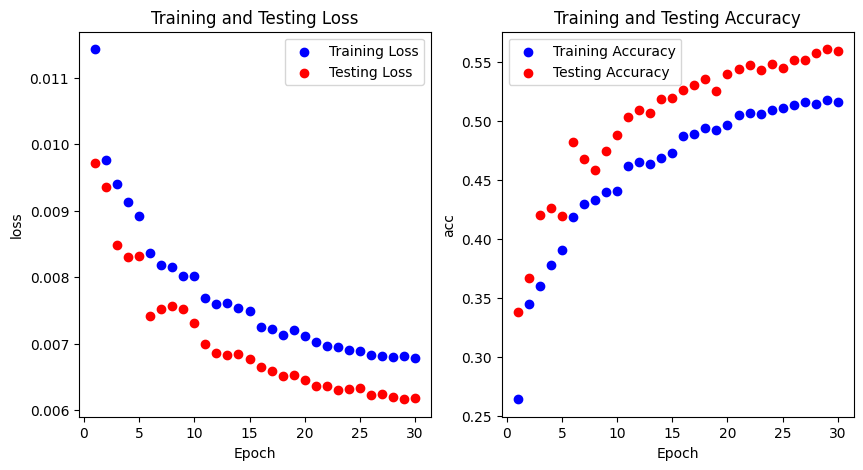

In [13]:
model,optimizer,scheduler = initial_Model()
FL2_tn_acc,FL2_tn_loss,FL2_tn_p,FL2_tt_acc,FL2_tt_loss,FL2_tt_p,FL2_tn_f1,FL2_tt_f1 = model_training(model,FocalLoss(gamma = 2),optimizer,scheduler)

Epoch: 1/30 Train Loss: 0.0137 Acc: 0.2915 Precision: 0.2848 f1: 0.2839
Begin test......
Test Loss: 0.0126 Acc: 0.3653 Precision: 0.3826 f1: 0.3584
Epoch: 2/30 Train Loss: 0.0125 Acc: 0.3532 Precision: 0.3483 f1: 0.3485
Begin test......
Test Loss: 0.0120 Acc: 0.3807 Precision: 0.4000 f1: 0.3686
Epoch: 3/30 Train Loss: 0.0122 Acc: 0.3621 Precision: 0.3582 f1: 0.3581
Begin test......
Test Loss: 0.0114 Acc: 0.4145 Precision: 0.4175 f1: 0.4073
Epoch: 4/30 Train Loss: 0.0120 Acc: 0.3744 Precision: 0.3700 f1: 0.3700
Begin test......
Test Loss: 0.0115 Acc: 0.4159 Precision: 0.4147 f1: 0.4055
Epoch: 5/30 Train Loss: 0.0118 Acc: 0.3890 Precision: 0.3851 f1: 0.3852
Begin test......
Test Loss: 0.0111 Acc: 0.4365 Precision: 0.4252 f1: 0.4199
Epoch: 6/30 Train Loss: 0.0111 Acc: 0.4242 Precision: 0.4192 f1: 0.4198
Begin test......
Test Loss: 0.0102 Acc: 0.4690 Precision: 0.4591 f1: 0.4581
Epoch: 7/30 Train Loss: 0.0109 Acc: 0.4319 Precision: 0.4275 f1: 0.4276
Begin test......
Test Loss: 0.0106 Acc: 

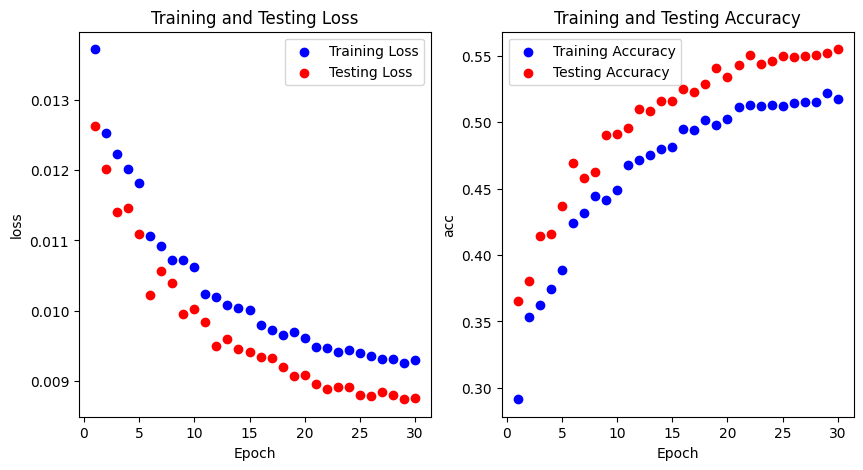

In [14]:
model,optimizer,scheduler = initial_Model()
FL05_tn_acc,FL05_tn_loss,FL05_tn_p,FL05_tt_acc,FL05_tt_loss,FL05_tt_p,FL05_tn_f1,FL05_tt_f1 = model_training(model,FocalLoss(gamma = 0.5),optimizer,scheduler)

## data analysis
### Draw the last training and testing accuracy

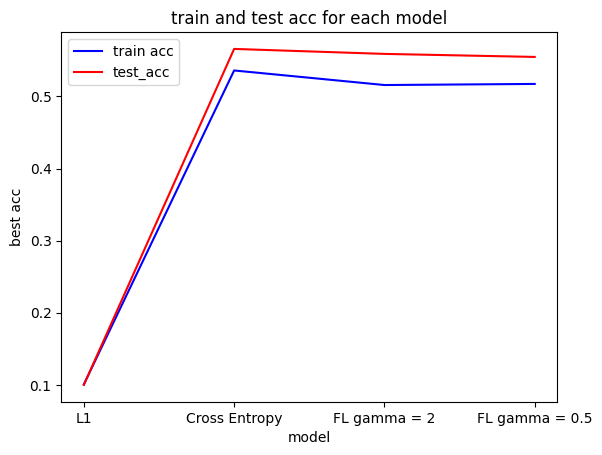

In [15]:
train_acc = [L1_tn_acc[-1],CE_tn_acc[-1],FL2_tn_acc[-1],FL05_tn_acc[-1]]
test_acc = [L1_tt_acc[-1],CE_tt_acc[-1],FL2_tt_acc[-1],FL05_tt_acc[-1]]
x = [1,2,3,4]
x_label = ['L1','Cross Entropy','FL gamma = 2','FL gamma = 0.5']
plt.plot(x,train_acc,color = 'blue',label = 'train acc')
plt.plot(x,test_acc,color = 'red',label = 'test_acc')
plt.xticks(x, x_label)
plt.title('train and test acc for each model')
plt.xlabel('model')
plt.ylabel('best acc')
plt.legend()

### Draw the accuracy of each epoch for training and testing

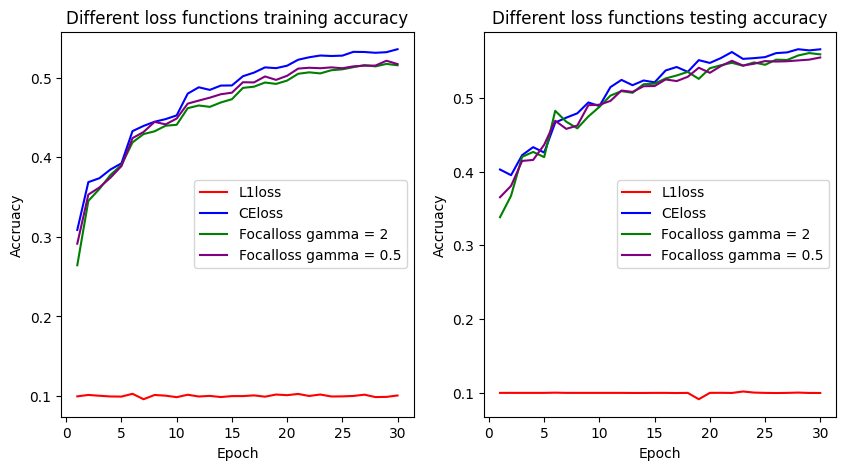

In [16]:
x = [i for i in range(1, NUM_EPOCHS+1)]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x,L1_tn_acc,color = "red",label = 'L1loss')
plt.plot(x,CE_tn_acc,color = "blue",label = 'CEloss')
plt.plot(x,FL2_tn_acc,color = "green",label = 'Focalloss gamma = 2')
plt.plot(x,FL05_tn_acc,color = "purple",label = 'Focalloss gamma = 0.5')
plt.title('Different loss functions training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accruacy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x,L1_tt_acc,color = "red",label = 'L1loss')
plt.plot(x,CE_tt_acc,color = "blue",label = 'CEloss')
plt.plot(x,FL2_tt_acc,color = "green",label = 'Focalloss gamma = 2')
plt.plot(x,FL05_tt_acc,color = "purple",label = 'Focalloss gamma = 0.5')
plt.title('Different loss functions testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accruacy')
plt.legend()
plt.tight_layout
plt.show()

### Draw the precision of each epoch for training and testing

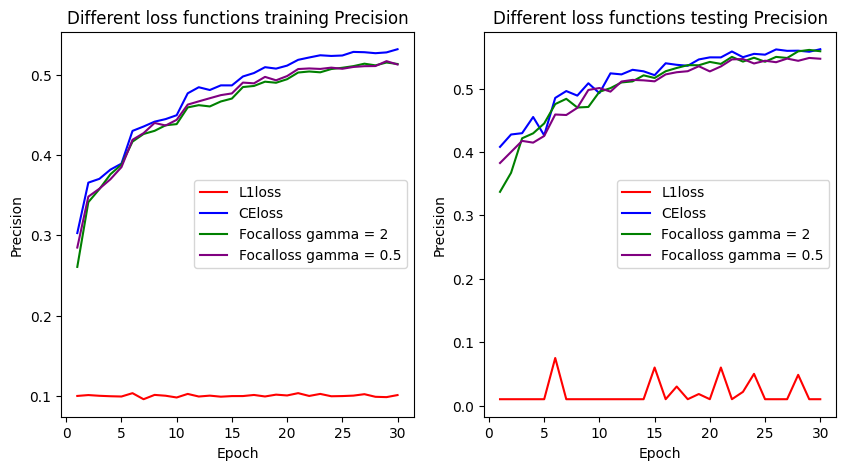

In [17]:
x = [i for i in range(1, NUM_EPOCHS+1)]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x,L1_tn_p,color = "red",label = 'L1loss')
plt.plot(x,CE_tn_p,color = "blue",label = 'CEloss')
plt.plot(x,FL2_tn_p,color = "green",label = 'Focalloss gamma = 2')
plt.plot(x,FL05_tn_p,color = "purple",label = 'Focalloss gamma = 0.5')
plt.title('Different loss functions training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x,L1_tt_p,color = "red",label = 'L1loss')
plt.plot(x,CE_tt_p,color = "blue",label = 'CEloss')
plt.plot(x,FL2_tt_p,color = "green",label = 'Focalloss gamma = 2')
plt.plot(x,FL05_tt_p,color = "purple",label = 'Focalloss gamma = 0.5')
plt.title('Different loss functions testing Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout
plt.show()

### Draw the F1 of each epoch for training and testing

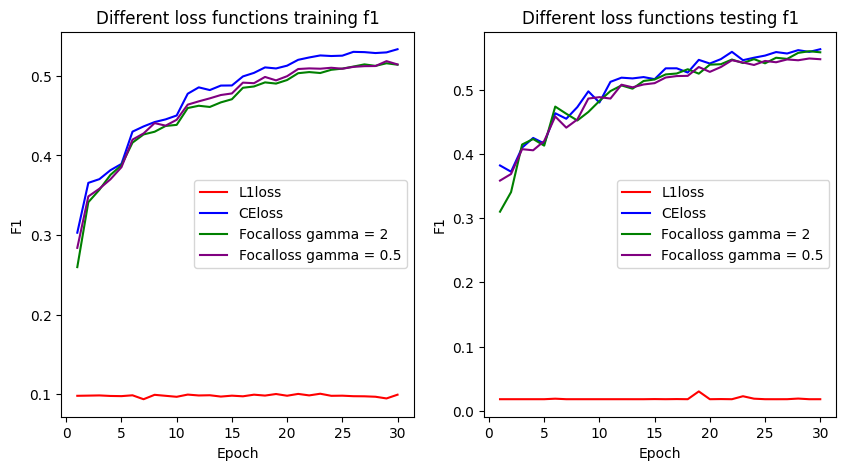

In [18]:
x = [i for i in range(1, NUM_EPOCHS+1)]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x,L1_tn_f1,color = "red",label = 'L1loss')
plt.plot(x,CE_tn_f1,color = "blue",label = 'CEloss')
plt.plot(x,FL2_tn_f1,color = "green",label = 'Focalloss gamma = 2')
plt.plot(x,FL05_tn_f1,color = "purple",label = 'Focalloss gamma = 0.5')
plt.title('Different loss functions training f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x,L1_tt_f1,color = "red",label = 'L1loss')
plt.plot(x,CE_tt_f1,color = "blue",label = 'CEloss')
plt.plot(x,FL2_tt_f1,color = "green",label = 'Focalloss gamma = 2')
plt.plot(x,FL05_tt_f1,color = "purple",label = 'Focalloss gamma = 0.5')
plt.title('Different loss functions testing f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.tight_layout
plt.show()